In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss, roc_auc_score, roc_curve
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from utils.metrics_utils import display_metrics, plot_confusion_matrix, plot_roc_curve 
import joblib

In [42]:
# Load glove vectors
q1_glove = np.load("data/q1_glove.npy")
q2_glove = np.load("data/q2_glove.npy")

# Turn them into DataFrames with proper column names
q1_glove_df = pd.DataFrame(q1_glove, columns=[f"q1_glove_{i}" for i in range(q1_glove.shape[1])])
q2_glove_df = pd.DataFrame(q2_glove, columns=[f"q2_glove_{i}" for i in range(q2_glove.shape[1])])

# Load main dataframe and merge glove features
df_glove = pd.read_csv("data/df_glove.csv")
df_glove = pd.concat([df_glove.reset_index(drop=True), q1_glove_df, q2_glove_df], axis=1)

In [16]:
# Split into train/val (85/15) with stratification on label
train_df, val_df = train_test_split(df_glove, test_size=0.15, stratify=df_glove['is_duplicate'], random_state=42)

In [6]:
scaler_glove = joblib.load("data/scaler_glove.pkl")

In [24]:
feature_cols = scaler_glove.feature_names_in_.tolist()

In [25]:
X_train = scaler_glove.transform(train_df[feature_cols])
X_val = scaler_glove.transform(val_df[feature_cols])

In [27]:
y_train = train_df['is_duplicate'].values
y_val = val_df['is_duplicate'].values

In [32]:
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_train = y_train.astype(np.int64)
y_val = y_val.astype(np.int64)

In [28]:
class QQPDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)      # shape [N, 4*embedding_dim]
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_data = QQPDataset(X_train, y_train)
val_data   = QQPDataset(X_val, y_val)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
print("Using device:", device)
if device.type == 'cuda':
    print("CUDA device name:", torch.cuda.get_device_name(0))

Using device: cuda
CUDA device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [33]:
class GloveNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_classes=2, dropout=0.2):
        super(GloveNNClassifier, self).__init__()
        
        self.net = nn.Sequential(
            # First layer
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            # Second layer with reduced dimensions
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            # Third layer with further reduction
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            # Output layer
            nn.Linear(hidden_dim // 4, num_classes)
        )
        
    def forward(self, x):
        return self.net(x)

# Calculate class weights to handle imbalance
class_counts = np.bincount(y_train)
class_weights = torch.FloatTensor(len(class_counts) / (class_counts * len(class_counts))).to(device)

input_dim = X_train.shape[1]
model = GloveNNClassifier(input_dim=input_dim, hidden_dim=512, dropout=0.2)
model.to(device)

# Use weighted CrossEntropyLoss to handle class imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Use AdamW optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Training parameters
num_epochs = 10
best_val_acc = 0.0
patience = 5  # for early stopping
no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.float().to(device) 
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    
    avg_loss = total_loss / len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.float().to(device)  # ADD .float()
            outputs = model(X_batch)    
            preds = outputs.argmax(dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(y_batch.numpy())
    
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)
    
    print(f"Epoch {epoch+1}: Train loss={avg_loss:.4f}, Val accuracy={val_acc:.4f}, Val F1={val_f1:.4f}")
    
    # Learning rate scheduling based on validation F1 score
    scheduler.step(val_f1)
    
    # Save best model and handle early stopping
    if val_f1 > best_val_acc:
        best_val_acc = val_f1
        torch.save(model.state_dict(), 'glove_nn_model.pt')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered!")
            break

# Load best model
model.load_state_dict(torch.load('glove_nn_model.pt'))

Epoch 1: Train loss=0.4778, Val accuracy=0.7757, Val F1=0.7379
Epoch 2: Train loss=0.4318, Val accuracy=0.7843, Val F1=0.7490
Epoch 3: Train loss=0.4086, Val accuracy=0.8009, Val F1=0.7569
Epoch 4: Train loss=0.3917, Val accuracy=0.8031, Val F1=0.7647
Epoch 5: Train loss=0.3781, Val accuracy=0.8067, Val F1=0.7669
Epoch 6: Train loss=0.3682, Val accuracy=0.8104, Val F1=0.7685
Epoch 7: Train loss=0.3582, Val accuracy=0.8116, Val F1=0.7684
Epoch 8: Train loss=0.3506, Val accuracy=0.8087, Val F1=0.7713
Epoch 9: Train loss=0.3444, Val accuracy=0.8084, Val F1=0.7717
Epoch 10: Train loss=0.3397, Val accuracy=0.8180, Val F1=0.7721


C:\Users\Galyna\AppData\Local\Temp\ipykernel_18368\1980304024.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


<All keys matched successfully>

#### Let's evaluate the model on the validation dataset. 

Accuracy : 0.8180
Precision: 0.7180
Recall   : 0.8351
F1 Score : 0.7721
Log-Loss : 0.3722
ROC AUC  : 0.9078


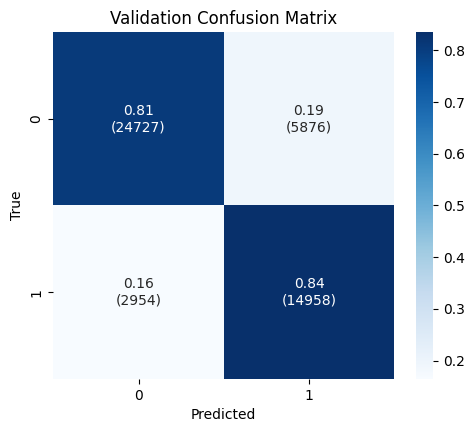

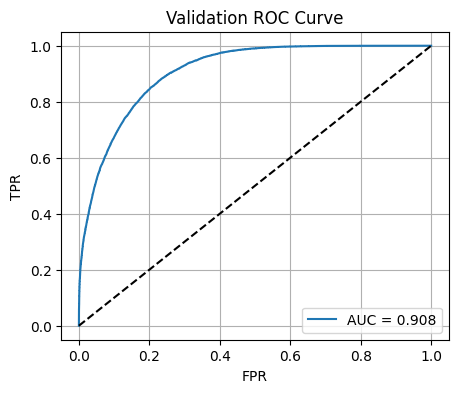

In [ ]:
model.eval()
y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for X_batch, y_batch in val_loader: 
        X_batch = X_batch.float().to(device)
        outputs = model(X_batch)  # shape [batch, num_classes]
        probs = torch.softmax(outputs, dim=1)  # Get probabilities
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())
        y_prob.extend(probs[:, 1].cpu().numpy())  # Probabilities for class 1

# Now just call your functions!
display_metrics(y_true, y_pred, y_prob)
plot_confusion_matrix(y_true, y_pred, labels=["0", "1"], title="Validation Confusion Matrix")
plot_roc_curve(y_true, y_prob, title="Validation ROC Curve")

#### Let's evaluate the model on the test dataset. 

In [54]:
df_test = pd.read_csv('data/quora_test.csv.zip', index_col=0)
pd.set_option('display.max_colwidth', None)

In [56]:
X_test = np.load("data/X_test_glove_scaled.npy").astype(np.float32)
y_test = np.load("data/y_test.npy")

In [58]:
test_data   = QQPDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size)

model.load_state_dict(torch.load("best_model.pt"))
model.eval()

C:\Users\Galyna\AppData\Local\Temp\ipykernel_18368\292364552.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


CBOWClassifier(
  (net): Sequential(
    (0): Linear(in_features=608, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=2, bias=True)
  )
)

Accuracy : 0.8171
Precision: 0.7172
Recall   : 0.8330
F1 Score : 0.7708
Log-Loss : 0.3760
ROC AUC  : 0.9064


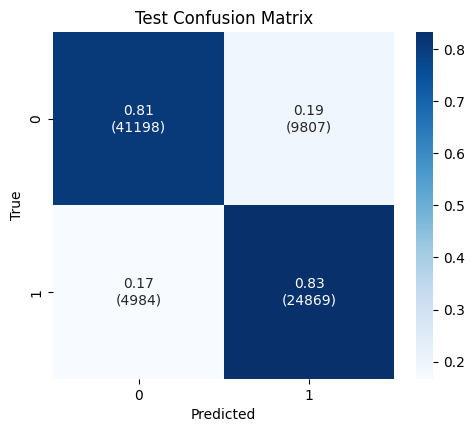

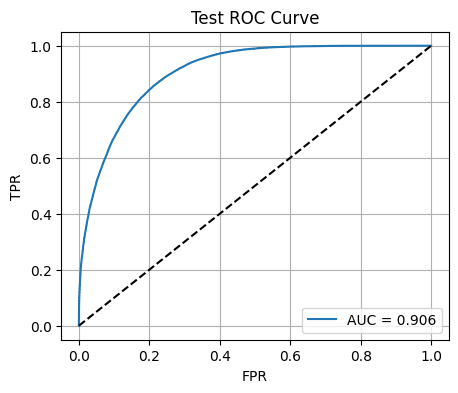

In [59]:
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        out  = model(Xb)
        prob = torch.softmax(out, dim=1)

        y_true.extend(yb.cpu().numpy())
        y_pred.extend(out.argmax(1).cpu().numpy())
        y_prob.extend(prob[:, 1].cpu().numpy())

display_metrics(y_true, y_pred, y_prob)
plot_confusion_matrix(y_true, y_pred, labels=["0", "1"],
                      title="Test Confusion Matrix")
plot_roc_curve(y_true, y_prob, title="Test ROC Curve")